In [1]:
import seaborn as sns
import pandas as pd
import scipy as sp
import numpy as np
import time
seed = 14
np.random.seed(seed)

from keras import backend as K, activations
from keras import layers
from keras import regularizers
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score

from matplotlib import pyplot as plt

Using TensorFlow backend.


In this notebook we will test neural-network classification models for classifying biological traits based on gene expression data. We will start by exploring different neural network architectures for a given trait, and then move to investigating the use of deep learning visualization techniques (saliency maps and activation maximization) in order to identify input patterns important for each classification model.

--------------------------------

# Before we start - handling input data:

### 1. Choosing the biological trait of focus in this analysis
Choose one of the following traits:

In [3]:
myTrait = 'stimulation'  # IFNb, LPS, dNS1, unstim
# myTrait = 'gender'      # F, M
# myTrait = 'ethnicity'   # African-American, Caucasian, East Asian, MULTI-RACIAL

### 2. Loading the gene expression data:
The gene expression data is provided as two seperated files: <br>
(a) The gene expression table, consisting of 414 genes measured across 2441 samples <br>
(b) The features table, including info such as stimultaion, gender and ethnicity origin of the 2441 samples

In [4]:
features_table = pd.read_table('Input/features.txt')
features = features_table.set_index('geo_accession')
features = np.transpose(features)

In [5]:
GE_table = pd.read_table('Input/GE.txt')
GE = GE_table.set_index('ID_REF')
GE = np.transpose(GE)

<b> Normalizaition </b> - Choose whether or not to normalize the gene expression using Z-scores:

In [6]:
normalize = True
# normalize = False

if normalize:
    GE = (GE - GE.mean())/(GE.std()) # normalizing GE by z-score for each gene
    print("Normalized GE")
else:
    print("Original GE")

Normalized GE


In [7]:
num_genes = GE.shape[1]
num_samples = GE.shape[0]

print('Number of genes: %i' %num_genes)
print('Number of samples: %i' %num_samples)

Number of genes: 414
Number of samples: 2441


### 3. Processing the data for classification of the selected trait:
<b> Input X </b> - a vector of 414 genes. <br>
<b> Output Y </b> - multiclass labeling (or the corresponding one-hot codded representation, dummyY) of the selected trait (stimulation, gender or ethnicity).

In [8]:
# Creating the input matrix X and output matrix Y:
X = GE.values.astype(float)  
Y = features[myTrait]

classes, counts = np.unique(Y, return_counts=True)
num_classes = classes.size
print(dict(zip(classes, counts))) # Check the number of samples in each lable

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encodedY = encoder.transform(Y)

# Convert integers to dummy variables
dummyY = np_utils.to_categorical(encodedY)


{'IFNb': 432, 'LPS': 806, 'dNS1': 469, 'unstim': 734}


--------------------------------

# Part 1 - Testing neural networks architectures for the classification:
<b> Figure 1: </b> Three neural network architectures will be tested along this section: <br>

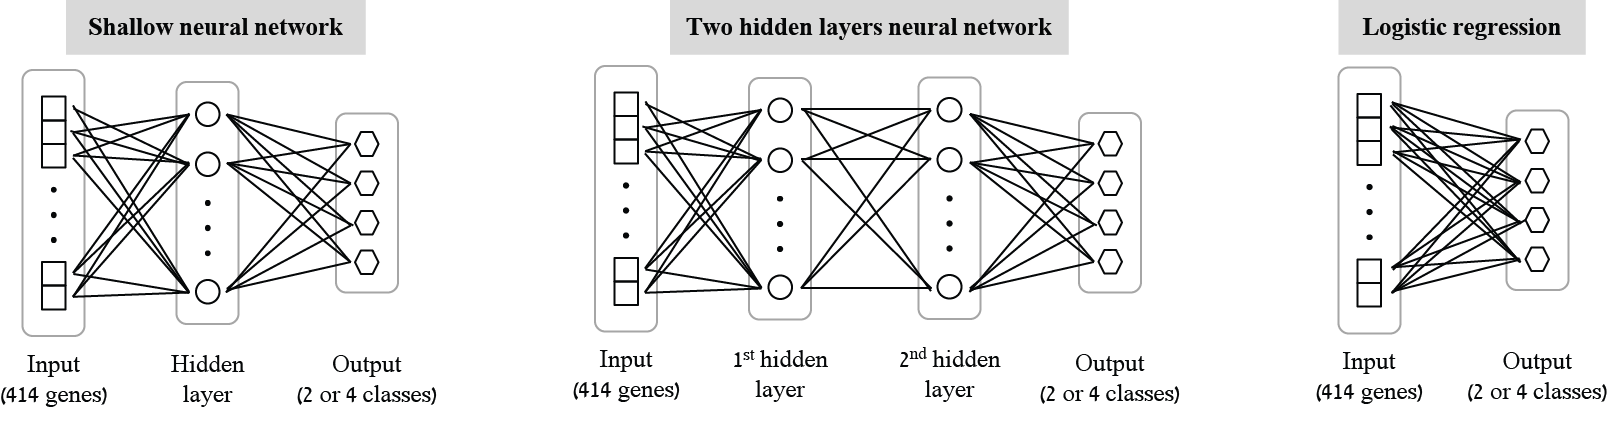

<b>[1] Shallow neural network</b> - a classification model with one-hidden layer. The number of neurons within the hidden layer is given as a parameter.

In [9]:
def build_shallow_network_model(X, dummyY, hidden_dim):
    input_dim = X.shape[1]  # 414 genes measures for each sample
    output_dim = dummyY.shape[1]  # 4 classes in case of stimulations & ethnicity, 2 classes in the case of gender
    
    inputs = Input(shape=(input_dim,))
    hidden = Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    outputs = Dense(output_dim, activation='softmax')(hidden)
    myModel = Model(inputs=inputs, outputs=outputs)
    myModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    
    return myModel

<b>[2] Two-hidden-layers neural network</b> - a classification model with two hidden layers. The number of neurons within each hidden layer are given as parameters.

In [10]:
def build_two_layer_network_model(X, dummyY, hidden_dim, hidden_dim_2):
    input_dim = X.shape[1]  # 414 genes measured for each sample
    output_dim = dummyY.shape[1]  # 4 classes in case of stimulations & ethnicity, 2 classes in the case of gender
    
    inputs = Input(shape=(input_dim,)) 
    hidden1 = Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    hidden2 = Dense(hidden_dim_2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(hidden1)
    predictions = Dense(output_dim, activation='softmax')(hidden2)
    myModel = Model(inputs=inputs, outputs=predictions)
    myModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return myModel

<b>[3] Logistic regression network</b> - a multiclass model without hidden layers.

In [11]:
def build_logistic_regression_model(X, dummyY):
    input_dim = X.shape[1]  # 414 genes measures for each sample
    output_dim = dummyY.shape[1]  # 4 classes in case of stimulations & ethnicity, 2 classes in the case of gender
    
    inputs = Input(shape=(input_dim,))
    outputs = Dense(output_dim, activation='softmax')(inputs)
    
    myModel = Model(inputs=inputs, outputs=outputs)
    myModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
    
    return myModel

Analysis is conducted by spliting the dataset into 10-folds, training and testing a model on each of the splits. Mean and standard deviation of the accuracy, precision, recall and F1 scores across the 10 splits are reported. Stratified cross validation is used to preserve the proportion of each class in each split.

In [12]:
def cross_validation_prediction(X, encodedY, dummyY, seed, hidden_dim, hidden_dim_2, debug):
    # Create 10-fold cross validation split:
    k = 10
    cv_scores = pd.DataFrame(np.zeros((k, 5)), columns = ['accuracy','precision','recall','f1','time'])
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    i=0
    for train, test in kfold.split(X,encodedY):
        # Choose the neural network architecture of the model:
        myModel = None
        if hidden_dim > 0:
            if hidden_dim_2 == 0:
                if i==0:
                    print("shallow neural network with " + str(hidden_dim) + " dim hidden layer:")
                myModel = build_shallow_network_model(X, dummyY, hidden_dim)  
            else:
                if i==0:
                    print("two-layer neural network with " + str(hidden_dim) + " and " + str(hidden_dim_2) + " dim hidden layer:")
                myModel = build_two_layer_network_model(X, dummyY, hidden_dim, hidden_dim_2)
        else:
            if i==0:
                print("logistic regression model:")
            myModel = build_logistic_regression_model(X, dummyY)

        # Fit model according to train set:    
        print("   split %i" %i)
        start_time = time.time()
        myModel.fit(X[train], dummyY[train], epochs=10, batch_size=5, verbose=0)
        cv_scores['time'] = time.time() - start_time

        # Evaluate accuracy on test set:
        scores = myModel.evaluate(X[test], dummyY[test], verbose=0)
        cv_scores['accuracy'][i] = scores[1] * 100
        if debug==True:
            print("%s: %.2f%%" % (myModel.metrics_names[1], scores[1]*100))
        
        # Eveluate precision, recall and f1 on test set:
        probs = myModel.predict(X[test], batch_size=5, verbose=0)
        predicted = np.argmax(probs, axis=1)
        true = encodedY[test]

        cv_scores['precision'][i] = 100*precision_score(true, predicted, average='weighted')
        cv_scores['recall'][i] = 100*recall_score(true, predicted, average='weighted')
        cv_scores['f1'][i] = 100*f1_score(true, predicted, average='weighted')
        i = i+1

        if debug == True:
            classes, counts = np.unique(predicted, return_counts=True)
            print("predicted:" + str(dict(zip(classes, counts))))
            classes, counts = np.unique(true, return_counts=True)
            print("true:" + str(dict(zip(classes, counts))))
            print("")        
    return cv_scores

### Testing different neural network architectures for classification of biological traits:

Here we test different neural network architectures to classify the chosen trait based on an input panel of the 414 genes expression levels for each of the 2441 sammple. The input is a matrix of shape (2441,414), the output is a dummy variable representaion of a label vector of shape (2441,1). Performance is measured based on 10-fold cross validation accuracy scores. Reported are the mean and standard deviation calculated across the splits.

    * For shallow network: hidden_dim > 0 + hidden_dim_2 = 0
    * For 2-layer network: hidden_dim > 0 + hidden_dim_2 > 0
    * For logistic regression: hidden_dim = 0

In [13]:
import warnings
warnings.filterwarnings("ignore")

architectures = [[2,0],[8,0],[16,0],[32,0],[64,0],[8,2],[16,8],[32,16],[0,0]]
mean_results = pd.DataFrame(np.zeros((len(architectures), 5)), columns = ['accuracy','precision','recall','f1','time'])
std_results = pd.DataFrame(np.zeros((len(architectures), 5)), columns = ['accuracy','precision','recall','f1','time'])

j=0
print("Testing " + str(len(architectures)) + " architectures for " + myTrait + ":")
print("----------------------------------------")
for architecture in architectures:
    cvscores = cross_validation_prediction(X, encodedY, dummyY, seed, architecture[0], architecture[1], debug=False)
    mean_results.iloc[j,:] = cvscores.mean()
    std_results.iloc[j,:] = cvscores.std()
    j=j+1

Testing 9 architectures for stimulation:
----------------------------------------
shallow neural network with 2 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9
shallow neural network with 8 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9
shallow neural network with 16 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9
shallow neural network with 32 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9
shallow neural network with 64 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9
two-layer neural network with 8 and 2 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   

In [14]:
mean_results_copy = mean_results.copy()
new_results = pd.DataFrame(index=mean_results.index,columns = mean_results.columns)
for row in range(mean_results.shape[0]):
    for col in range(mean_results.shape[1]-1):
        new_results.iloc[row,col] = ("%.2f (+/- %.2f)" % (mean_results.iloc[row,col], std_results.iloc[row,col]))
    new_results.iloc[row,col+1] = ("%.2f" % mean_results.iloc[row,col+1])
    
new_results

,accuracy,precision,recall,f1,time
0,93.81 (+/- 7.13),95.50 (+/- 4.69),93.81 (+/- 7.13),93.22 (+/- 8.19),4.10
1,98.89 (+/- 0.75),98.91 (+/- 0.73),98.89 (+/- 0.75),98.89 (+/- 0.75),5.06
2,98.65 (+/- 1.03),98.68 (+/- 0.97),98.65 (+/- 1.03),98.65 (+/- 1.03),5.77
3,97.95 (+/- 1.04),98.06 (+/- 0.95),97.95 (+/- 1.04),97.96 (+/- 1.04),7.64
4,98.24 (+/- 0.99),98.30 (+/- 0.93),98.24 (+/- 0.99),98.24 (+/- 0.99),11.05
5,98.81 (+/- 0.90),98.84 (+/- 0.86),98.81 (+/- 0.90),98.81 (+/- 0.90),11.81
6,98.69 (+/- 1.14),98.74 (+/- 1.04),98.69 (+/- 1.14),98.69 (+/- 1.14),11.86
7,98.65 (+/- 0.89),98.68 (+/- 0.85),98.65 (+/- 0.89),98.65 (+/- 0.89),15.21
8,98.81 (+/- 0.76),98.84 (+/- 0.73),98.81 (+/- 0.76),98.81 (+/- 0.76),14.90


In [15]:
 new_results.to_excel('Output/performance_analysis' + myTrait + '.xlsx', myTrait)

---------------

# Part 2 - Utilizing deep learning visualization methods to study input patterns

For this part of the analysis we will use a trained model of shallow network with a hidden layer of 8 neurons:

In [16]:
myModel = None
myModel = build_shallow_network_model(X, dummyY, 8)  
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X,encodedY):
    continue

myModel.fit(X[train], dummyY[train], epochs=10, batch_size=5, verbose=0)
scores = myModel.evaluate(X[test], dummyY[test], verbose=0)
print("Model accuracy: " + str(scores[1]*100))

Model accuracy: 98.76033038147224


Convert the softmax activation output to a linear output (needed for both visualizations):

In [17]:
from vis.utils import utils

myModel.layers[-1].activation = activations.linear
myModel = utils.apply_modifications(myModel)

### Saliency Maps:
Saliency Maps are commonly used for revealing a trained neural netowrk's attention given to specific patterns in the input. This is conducted by quantifying the impact that a small change in an input component has on correctly classifying the input vector.
Here, we conduct saliency maps analysis to quantify the amount of attention a trained model is giving to each of the genes in each of the sample. Samples are then grouped based on their trait class.

Code is based on https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html and https://raghakot.github.io/keras-vis/visualizations/saliency/, adapted for the case of an input vector (instead of an input image).

In [18]:
def my_saliency_map(myModel, class_idx, sample_vec):    
    input_vec = myModel.input
    output_vec = myModel.output[:, class_idx]    
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(myModel.output[:, class_idx])  
 
    # Compute the gradient of the output vector w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(output_vec, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Gradient descent on the given sample_vec:
    alpha = 0.1
    num_steps = 1
    
    sample_vec = sample_vec.reshape(1,num_genes)
    for i in range(num_steps):
        loss_value, grads_value = iterate([sample_vec])
        grads_value -= grads_value*alpha
    
    return grads_value[0]

In the following cell we aim to visualize the <b>saliency maps</b> obtained for each of the samples on the test set, and compare them to the original gene expression, while grouping the sampls according to their labeling. We further calculate the <b>averaged saliency maps</b> for each class by averaging the attention scores of all samples within each class.

In [19]:
# Create dataframes of gene expression and saliency maps of size num_genes X num_samples:
genes = GE.columns.values.tolist()
expression_all_samples =  pd.DataFrame(genes, columns=['Gene'])
saliency_all_samples =  pd.DataFrame(genes, columns=['Gene'])

# Create a dataframe of averaged saliency maps of size num_genes X num_classes:
saliency_average_samples = pd.DataFrame(genes, columns=['Gene'])

# Saving the attention scores to an output file:
filepath = 'Output/' + myTrait + '_saliency_maps_v2.xlsx'
writer = pd.ExcelWriter(filepath)

# For every class - 
# (i)  Go through each relevant sample to retrieve gene expression and calculate saliency map 
# (ii) Caclulate the averaged saliency across all relevant samples
class_idx=0
for class_label in np.unique(Y): 
    print(class_label)
 
    i=0
    class_samples_indices = np.where(encodedY[test]==class_idx)[0]
    np.random.shuffle(class_samples_indices)   
    num_class_samples = len(class_samples_indices)
    
    class_expression = pd.DataFrame(np.zeros((num_genes, num_class_samples)),columns=[class_label + '_' + str(x) for x in range(num_class_samples)])
    class_saliency = pd.DataFrame(np.zeros((num_genes, num_class_samples)),columns=[class_label + '_' + str(x) for x in range(num_class_samples)])
    
    for sample_idx in class_samples_indices:       
        sample_vec = X[test][sample_idx]
        class_expression.iloc[:,i] = sample_vec
        
        saliency_vec = my_saliency_map(myModel, class_idx, sample_vec)
        class_saliency.iloc[:,i] = saliency_vec
        i+=1
    
    expression_all_samples = expression_all_samples.join(class_expression)
    saliency_all_samples = saliency_all_samples.join(class_saliency)
    saliency_average_samples[class_label] = np.mean(class_saliency,axis=1)

    class_saliency = saliency_all_samples['Gene'].to_frame().join(class_saliency)   
    class_saliency.to_excel(writer,class_label)
    writer.save()
        
    class_idx+=1

IFNb
LPS
dNS1
unstim


<b>Figure 2:</b> Plotting the gene expression measurements (top) vs. the calculated saliency maps (bottom) for each sample in test set. Samples are grouped by left to right according to class labels.

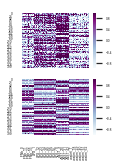

In [20]:
sns.set(font_scale=0.3)

f,(ax1,ax2) = plt.subplots(2,1, figsize=(1.5,2.25), sharex=True)
g1 = sns.heatmap(expression_all_samples.iloc[:,1:],ax=ax1, cmap="BuPu", vmin=-1, vmax=1)
g2 = sns.heatmap(saliency_all_samples.iloc[:,1:],ax=ax2, cmap="BuPu", vmin=-1, vmax=1)
plt.savefig('Output/' + myTrait + '_GE_and_SM_fixed_scale_BuPu.jpg', dpi = 1200)

### Activation Maximization:
Activation Maximization is a common method that can be used to generate an input instance that maximizes the activation of a specific class. Here we use the activation maximiaztion to identify gene expression patterns within the input that are important for the classification of each trait. We compare the <b>activation maximiaztion</b> scores calculated for each class to the averaged saliency maps calculate above.

Code is based on https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html and https://raghakot.github.io/keras-vis/visualizations/activation_maximization/, adapted for the case of an input vector (instead of an input image).

In [21]:
def my_activation_maximization(myModel, class_idx):    
    input_vec = myModel.input
    output_vec = myModel.output[:, class_idx] 
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(myModel.output[:, class_idx]) 
        
    # Compute the gradient of the loss w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(loss, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Start gradient ascent from a random input vector:
    rand_vec = np.random.random((1, input_vec.shape[1]))
    
    # Gradient ascent:
    alpha = 0.1
    num_steps = 5
    for i in range(num_steps):
        loss_value, grads_value = iterate([rand_vec])
        rand_vec += grads_value*1.
        
    rand_vec = np.transpose(rand_vec)
    
    return rand_vec

In [22]:
# Create a dataframe of activation maximization scores of size num_genes X num_classes:
genes = GE.columns.values.tolist()
act_max =  pd.DataFrame(genes, columns=['Gene'])

# Computing activation maximization for each class:
class_idx=0
for class_label in np.unique(Y): 
    print(class_label)
    
    act_max[class_label] = my_activation_maximization(myModel, class_idx)        
    class_idx+=1
    
filepath = 'Output/' + myTrait + '_ASM_and_AM_scores_v2.xlsx'
writer = pd.ExcelWriter(filepath)
saliency_average_samples.to_excel(writer,'averaged_saliency')
act_max.to_excel(writer,'activation_maximization')
writer.save()

IFNb
LPS
dNS1
unstim


<b>Figure 3:</b> Plotting the averaged saliency maps (left) vs. the calculated activation maximization scores (left) for each class label.

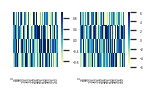

In [23]:
sns.set(font_scale=0.3)

if myTrait=='gender':
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(2.2,0.5), sharey=True)
else:
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(2.2,1), sharey=True)
sns.heatmap(np.transpose(saliency_average_samples.iloc[:,1:]),cmap="YlGnBu", ax=ax0, vmin=-1, vmax=1, yticklabels=False)
sns.heatmap(np.transpose(act_max.iloc[:,1:]),cmap="YlGnBu", ax=ax1, vmin=-6, vmax=6, yticklabels=False)
plt.subplots_adjust(wspace = 0.2)
plt.savefig('Output/' + myTrait + '_ASM_and_AM_fixed_scale.jpg', dpi = 1200)

In [24]:
print("Correlation between activation maximization and averaged saliency maps:")
act_max.corrwith(saliency_average_samples)

Correlation between activation maximization and averaged saliency maps:


IFNb      0.989857
LPS       0.994428
dNS1      0.985977
unstim    0.968966
dtype: float64

--------------------------------

# Part 3 - Investigating classification based only on trait-specific genes

In this section we show that the performance of a shallow network classification model is not compromised when using only the top scoring genes of each class as input (as opposed to using all 414 genes). Given the high correlation between saliency maps and activation maximization scores, we will focus on the top activation maximization genes.

We define the <b> top-K genes</b> for a given biological trait as the genes that obtained the highest scores when calculating activation maximization with respect to this trait (Part 2). Since activation maximization scores were calculated for each gene  per class, we average the scores of a gene across the classes to obtain a <b> trait-specific gene score</b>. 
(Note that average is taken across classes, and not maximum, to prioritize genes that obtained high scores in more than one class; absolute value is taken for highly positive or highly negative scores both contribute to the classification).

In [25]:
genes = GE.columns.values.tolist()
act_max_scores = act_max.copy()
act_max_scores['avg_abs_activation'] = (act_max[classes]).abs().mean(axis=1)
act_max_scores = act_max_scores.sort_values(by=['avg_abs_activation'], ascending=False)
sorted_genes_act_max = act_max_scores['Gene'].tolist()

act_max_scores.head(10)

,Gene,IFNb,LPS,dNS1,unstim,avg_abs_activation
162,IFIT2,6.554671,11.156708,2.923445,-16.728799,9.340906
200,IL6,-3.147135,14.514496,3.221635,-14.781904,8.916292
160,IFI44,8.481243,8.872343,2.406007,-13.521151,8.320186
326,SCG3,-8.298208,-7.243618,2.811597,14.625813,8.244809
163,IFIT5,5.962360,11.858452,3.297907,-10.786889,7.976402
218,KLF4,-6.396861,-11.035489,12.709010,1.512871,7.913558
5,ADCY3,-6.714064,14.676614,-2.385396,-7.876364,7.913110
190,IL1B,-2.881884,17.390721,-0.424469,-10.882217,7.894823
392,TRIM25,6.545656,10.857827,-0.957409,-10.921106,7.320499
95,DTX4,-5.211190,14.305078,-5.974461,-3.365779,7.214127


We further focus on exploring the similarity between the activation maximization scores and regression coefficients, which are traditionally used to measure effect sized in logistic regressions. We similarly define the top-K genes as those obtaining the strongest averaged regression coefficients.

In [26]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, encodedY)

genes = GE.columns.values.tolist()
beta_df =  pd.DataFrame(genes, columns=['Gene'])
beta_df = beta_df.join(pd.DataFrame(clf.coef_.transpose()))

beta_df['max_abs_coef'] = (beta_df.iloc[:, 1:]).abs().max(axis=1)

filepath = 'Output/' + myTrait + '_betas_scores.xlsx'
writer = pd.ExcelWriter(filepath)
beta_df.to_excel(writer,'beta')
writer.save()

beta_df = beta_df.sort_values(by=['max_abs_coef'], ascending=False)
sorted_genes_standard_form = beta_df['Gene'].tolist()

beta_df.head(10)

,Gene,0,1,2,3,max_abs_coef
200,IL6,-0.116234,0.420073,0.042621,-0.346459,0.420073
162,IFIT2,0.037758,0.271927,0.059883,-0.369568,0.369568
201,IL7,0.082728,0.219389,0.025752,-0.327869,0.327869
190,IL1B,-0.075075,0.310837,-0.009300,-0.226462,0.310837
160,IFI44,0.063529,0.194837,0.030307,-0.288673,0.288673
95,DTX4,-0.051450,0.278628,-0.067540,-0.159638,0.278628
211,IRG1,-0.068379,0.249482,-0.027365,-0.153738,0.249482
326,SCG3,-0.095946,-0.113775,-0.039691,0.249412,0.249412
192,IL1RN,0.083645,-0.248416,0.029901,0.134870,0.248416
194,IL28A,-0.161329,-0.091588,0.247319,0.005598,0.247319


Choose the number of genes (the top-K threshold) which will be used as input to the classification model and calculate the accuracy of a shallow neural network with this reduced input:

In [32]:
# k = 1
# k = 2
# k = 3
# k = 5
k = 10
# k = 20
# k = 50
# k = 100
# k = 200

In [33]:
# Top-K genes based on activaiton mazimization:
top_k_act_max_GE = GE[sorted_genes_act_max[0:k]]
X_top_act_max = top_k_act_max_GE.values.astype(float)  

act_max_cvscores = cross_validation_prediction(X_top_act_max, encodedY, dummyY, seed, 8, 0, debug=False)
print("\nClassification based on top %i activation maximization genes: %.2f%% (+/- %.2f%%)" % (k, np.mean(act_max_cvscores['accuracy']), np.std(act_max_cvscores['accuracy'])))

shallow neural network with 8 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9

Classification based on top 10 activation maximization genes: 98.23% (+/- 1.04%)


In [34]:
# Top-K genes based on standard logistic regression:
standard_form_GE = GE[sorted_genes_standard_form[0:k]]
X_standard_form = standard_form_GE.values.astype(float)  

standard_form_cvscores = cross_validation_prediction(X_standard_form, encodedY, dummyY, seed, 8, 0, debug=False)
print("\nClassification based on top %i closed-form genes: %.2f%% (+/- %.2f%%)" % (k, np.mean(standard_form_cvscores['accuracy']), np.std(standard_form_cvscores['accuracy'])))

shallow neural network with 8 dim hidden layer:
   split 0
   split 1
   split 2
   split 3
   split 4
   split 5
   split 6
   split 7
   split 8
   split 9

Classification based on top 10 closed-form genes: 98.56% (+/- 1.03%)


Print the sorted list of genes based on either activation maximization scores or regression coefficients:

In [38]:
sorted_genes_act_max

['IFIT2',
 'IL6',
 'IFI44',
 'SCG3',
 'IFIT5',
 'KLF4',
 'ADCY3',
 'IL1B',
 'TRIM25',
 'DTX4',
 'ATP1B1',
 'DUSP6',
 'IL28A',
 'MX1',
 'IRF7',
 'TYK2',
 'DEPDC7',
 'RBM43',
 'DDX58',
 'PI4K2B',
 'GAPDH',
 'CDC37',
 'PGAP1',
 'IL28B',
 'SEMA3D',
 'OTUD5',
 'MAPK8',
 'SPRY2',
 'IFNA13',
 'CREM',
 'PTX3',
 'GPR68',
 'SLFN5',
 'MFN1',
 'MAP2K4',
 'HMGB3',
 'TNFSF10',
 'TNF',
 'SLC7A5',
 'MAP3K7',
 'STAT3',
 'IKBKB',
 'IFNA16',
 'STAT1',
 'PLK2',
 'STAT6',
 'OAS1',
 'CHUK',
 'ZFYVE16',
 'RGS2',
 'NFKB2',
 'TLR5',
 'P2RY13',
 'C9orf30',
 'IFNA4',
 'NMI',
 'IFNA2',
 'MAVS',
 'EIF4E3',
 'IFNAR2',
 'TLR6',
 'IL1F9',
 'IFI27',
 'RIPK1',
 'TRIM56',
 'IL29',
 'WDFY4',
 'IRG1',
 'CARD9',
 'XBP1',
 'IFIH1',
 'STAP1',
 'SIGLEC9',
 'FGD4',
 'RBM6',
 'IFNA14',
 'EHD1',
 'IFNA10',
 'IFNAR1',
 'GBP1',
 'ATP13A3',
 'SLC8A1',
 'MSR1',
 'TRAF1',
 'PAPD5',
 'PRRG4',
 'ABCF1',
 'MAP2K1',
 'COBLL1',
 'LRMP',
 'MAP3K8',
 'CUL4A',
 'LGALS2',
 'PPP6C',
 'ATF2',
 'STAT4',
 'TAB2',
 'SNORD3A',
 'MYD88',
 'AXL',
 'R

In [39]:
sorted_genes_standard_form

['IL6',
 'IFIT2',
 'IL7',
 'IL1B',
 'IFI44',
 'DTX4',
 'IRG1',
 'SCG3',
 'IL1RN',
 'IL28A',
 'IL1F9',
 'RBM43',
 'FGD4',
 'PTX3',
 'CLEC4D',
 'IL29',
 'PAPD5',
 'CCL7',
 'HSPA4L',
 'FAM135A',
 'CD24',
 'IL28B',
 'DCBLD1',
 'CDC37',
 'LRMP',
 'IFIT5',
 'STAT3',
 'IFNB1',
 'MMP10',
 'DUSP6',
 'IFNAR2',
 'DCTN5',
 'SLC7A5',
 'CLEC5A',
 'IFNA13',
 'PI4K2B',
 'LILRA3',
 'C9orf30',
 'ATP1B1',
 'PLK2',
 'MAP3K8',
 'HMGB3',
 'MAP2K2',
 'CD93',
 'MAP2K1',
 'RIPK1',
 'ZFP57',
 'TMEM173',
 'AIM2',
 'PDCD1',
 'GP1BA',
 'MED30',
 'HBEGF',
 'MAP3K7',
 'ADCY3',
 'MFN1',
 'P2RY13',
 'FCGR3A',
 'STAT1',
 'TNIP3',
 'TLR9',
 'IFNA2',
 'TNF',
 'IRAK1',
 'RHOH',
 'UNKL',
 'WDFY4',
 'IFNA14',
 'CREB1',
 'STAT6',
 'TBK1',
 'TNC',
 'FAM26F',
 'KLF4',
 'NDP',
 'NIPAL4',
 'JAK1',
 'ANKRD28',
 'TRAF3',
 'MUC2',
 'NMI',
 'TLR8',
 'PPP6C',
 'SEMA3D',
 'FAM120AOS',
 'GFRA2',
 'TLR7',
 'ELP2',
 'TLR6',
 'EDN1',
 'OAS1',
 'TNFRSF1A',
 'TLR5',
 'GAPDH',
 'NUPR1',
 'IRF7',
 'SPRY2',
 'DDX3Y',
 'ZFYVE16',
 'TNFSF10',
 '